In [1]:
%matplotlib ipympl

In [2]:
import cv2
import pickle
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d


In [3]:
path_current = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.split(path_current)[0])

from app_sys import AppSys
from utils_predict import standardize_fsize_coord_conversion, standardize_fsize
from utils import Holds, WallKeypoints

app_sys = AppSys()

# 1. Load kp coords

The coordinates recorded on tkinter canvas for squared (640x640) image

In [4]:
direc = os.path.join(app_sys.PATH_ASSET, 'concept_test')

In [5]:
os.listdir(direc)

['img1.pkl', 'camera_calibration', 'img0.pkl', 'kp1.pkl', 'kp0.pkl']

In [6]:
direc_img = pickle.load(open(os.path.join(direc,'img0.pkl'), 'rb'))
kp = pickle.load(open(os.path.join(direc,'kp0.pkl'), 'rb'))

In [7]:
print(direc_img)
direc_img_depth = direc_img.replace('original', 'depth')
print(direc_img_depth)

/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_original.jpg
/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_depth.jpg


# 2. Depth information

In [8]:
depth_array = np.load(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_depths.npz'))
depth_array

NpzFile '/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_depths.npz' with keys: depths

frame numbers, height, width

In [9]:
depth_array['depths'].shape

(654, 1280, 720)

The closer the larger the values -> the inverse distance is recorded

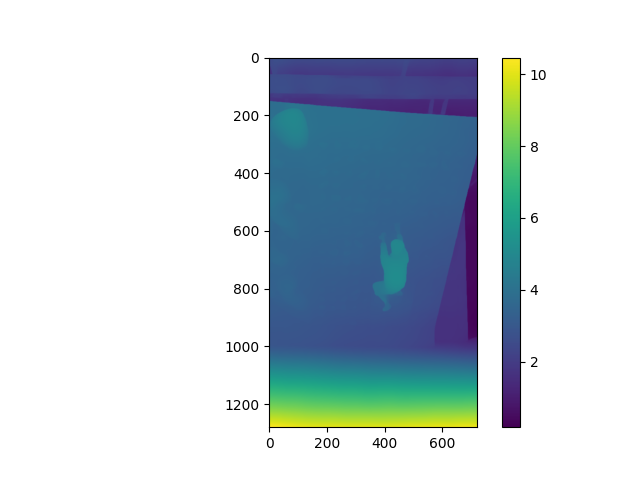

Max: 10.462610244750977, Min: 0.17370057106018066


In [10]:
plt.imshow(depth_array['depths'][0,:,:])
plt.colorbar()
plt.show()
print(f"Max: {depth_array['depths'][0,:,:].max()}, Min: {depth_array['depths'][0,:,:].min()}")

# 3. KP coordinates conversion from the square frame to the original frame

In [11]:
df_sq = pd.DataFrame(index=kp.get_node_names(), columns=['X', 'Y', 'Z'])
df_sq = df_sq.astype(float)
for key in df_sq.index:
    df_sq.loc[key, ['X', 'Y']] = kp.get_node_coords(key)

## Coordinates of the KPs on the square frame

In [12]:
df_sq

,X,Y,Z
A1,180.0,362.0,NaN
A4,181.0,325.0,NaN
A8,181.0,277.0,NaN
A11,182.0,236.0,NaN
A14,183.0,190.0,NaN
A18,184.0,118.0,NaN
C4,210.0,328.0,NaN
C6,211.0,304.0,NaN
C9,215.0,265.0,NaN
C12,217.0,221.0,NaN


In [13]:
# img = cv2.imread(direc_img)
# img_depth = cv2.imread(direc_img_depth)
# img_depth.shapepnp

## Coordinates of the KPs on the original video frames

Save the depth information

In [14]:
video = cv2.VideoCapture('/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_vis.mp4')
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
res, frame = video.read()

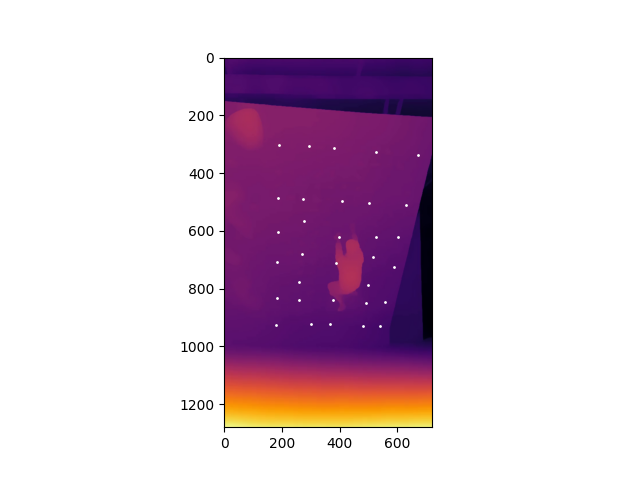

In [122]:
fig, ax = plt.subplots()
frame_depth = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
ax.imshow(frame_depth)

df = df_sq.copy()
# DF of the depth value
for k in df_sq.index:
    xx, yy = df_sq.loc[k, ['X', 'Y']]
    # Coordinates before reshaping the frame to 640x640
    x, y = standardize_fsize_coord_conversion(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_vis.mp4'), 640, (xx/500*640,yy/500*640))
    # ax.scatter(int(x), int(y), facecolors='none', color='white')
    ax.scatter(int(x), int(y), color='white', s=1)
    # values need to be inverted as they are likely inverse depth for visualisation purpose
    z = 1/(depth_array['depths'][0,y,x] + 1e-9) * 1000
    df.loc[k, ['X', 'Y', 'Z']] = (x,y,z)


In [18]:
df

,X,Y,Z
A1,181.0,927.0,351.897681
A4,183.0,832.0,319.867169
A8,183.0,709.0,301.018530
A11,186.0,604.0,284.308129
A14,188.0,486.0,271.009237
A18,191.0,302.0,253.646294
C4,258.0,840.0,328.265210
C6,260.0,778.0,322.211046
C9,270.0,678.0,292.029658
C12,276.0,566.0,282.983449


# 4. 3D visualisation of the KPs

In [19]:
dict_col = {
    'A':'red',
    'C':'orange',
    'D':'yellow',
    'E':'green',
    'F':'green',
    'H':'blue',
    'I':'navy',
    'K':'purple',
    }

Text(0.5, 0, 'Z')

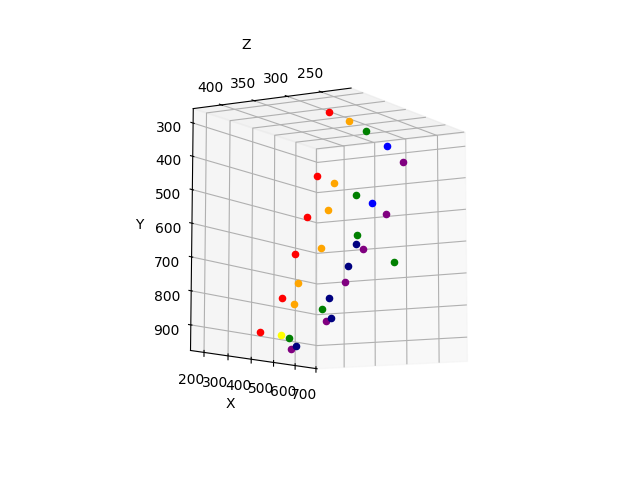

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df.index:
    x, y, z = df.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 5. Get the best fit plane

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

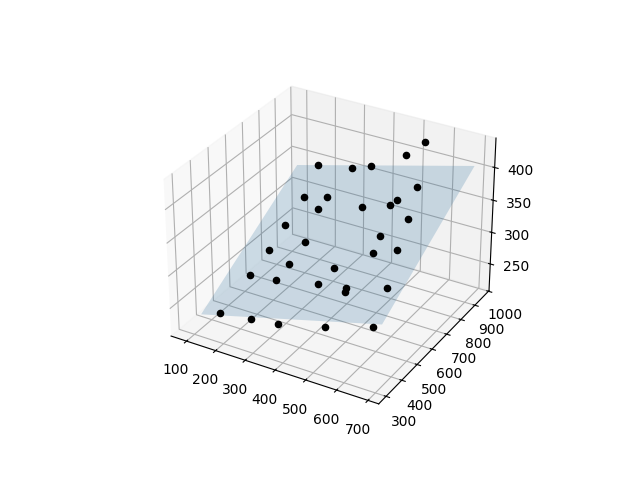

In [21]:
points = Points(df.astype(float))
plane = Plane.best_fit(points)

plot_3d(
    points.plotter(c='black', s=20, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-300, 300), lims_y=(-300, 300)),
)

# 6.  Projection of the KPs on the best fit plane

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

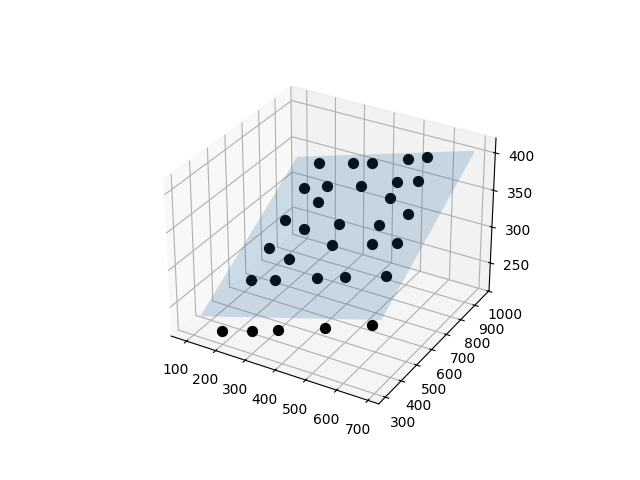

In [22]:
points2 = plane.project_points(df.astype(float))
plot_3d(
    points2.plotter(c='k', s=50, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-300, 300), lims_y=(-300, 300)),
)

In [23]:
df_fit = pd.DataFrame(points2, index=df.index, columns=df.columns)
df_fit

,X,Y,Z
A1,182.364555,929.102221,340.487455
A4,182.679856,831.506789,322.544173
A8,183.114854,709.176943,300.058136
A11,186.374518,604.576980,281.176456
A14,189.310283,488.018610,260.052824
A18,194.156023,306.862141,227.256048
C4,257.446530,839.147329,332.893251
C6,260.031740,778.048899,321.945638
C9,268.553948,675.772226,304.121352
C12,275.794196,565.682939,284.704359


Text(0.5, 0, 'Z')

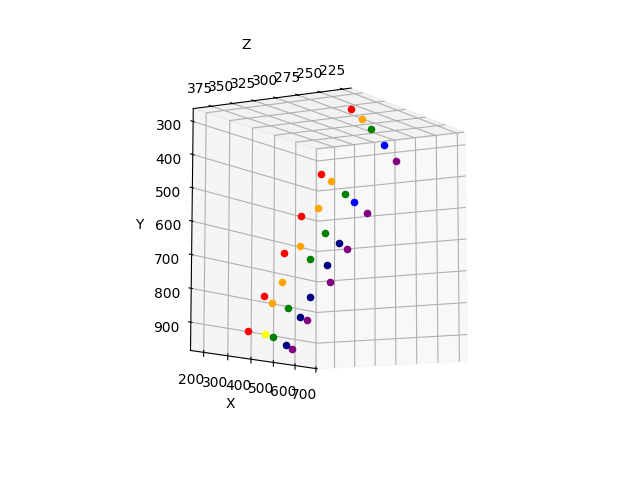

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df_fit.index:
    x, y, z = df_fit.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 8. Pseudo 3D coordinates of the KPs

Getting absolute X & Y coordinates assuming that Z we obtained are absolute depth

For most smartphone cameras, the principal point is near the center of the image:

In [25]:
import cv2
import numpy as np
import glob

# Define checkerboard properties
CHECKERBOARD = (9, 6)  # (internal corners per row, per column)
square_size = 0.015  # Set the square size in meters (e.g., 2.5cm = 0.025m)

# Arrays to store object points and image points
objpoints = []  # 3D world points
imgpoints = []  # 2D image points

# Define real-world 3D points for the checkerboard
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size

# Load all images from folder
images = glob.glob(direc + '/camera_calibration/*.JPG')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect checkerboard corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    
    if ret:
        print(f"✅ Pattern detected in {fname}")
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
    else:
        print(f"❌ Pattern NOT detected in {fname}")

# Camera calibration
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print results
print("\nCamera Matrix (K):\n", K)
print("\nDistortion Coefficients (D):\n", dist)


✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220112594LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220030216LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220057089LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220114955LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220019763LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220059527LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220016416LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220103774LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220046168

In [26]:
fx, fy = K[0,0], K[1,1]
cx, cy = K[:2,2]
print(f'fx, fy: {fx, fy}px\ncx, cy: {cx, cy}px')

fx, fy: (1353.6916013193747, 1357.5577175771411)px
cx, cy: (538.9620163208962, 961.5329947833661)px


## Estimate absolute X and Y (Not essential now)

X = (x-cx)/fx*Z

Y = (y-cy)/fy*Z


In [27]:
def abs_xy(row):
    return (row['X'] - cx)/fx*row['Z'], (row['Y'] - cy)/fy*row['Z'], row['Z']

In [28]:
df_abs = df_fit.apply(abs_xy, axis=1, result_type='expand')
df_abs.columns = ['X', 'Y', 'Z']
df_abs

,X,Y,Z
A1,-89.693223,-8.133924,340.487455
A4,-84.891370,-30.893121,322.544173
A8,-78.876781,-55.777729,300.058136
A11,-73.236255,-73.932494,281.176456
A14,-67.170337,-90.706090,260.052824
A18,-57.885598,-109.592328,227.256048
C4,-69.228918,-30.010777,332.893251
C6,-66.337403,-43.513365,321.945638
C9,-60.750076,-64.016395,304.121352
C12,-55.348667,-83.016902,284.704359


Text(0.5, 0, 'Z')

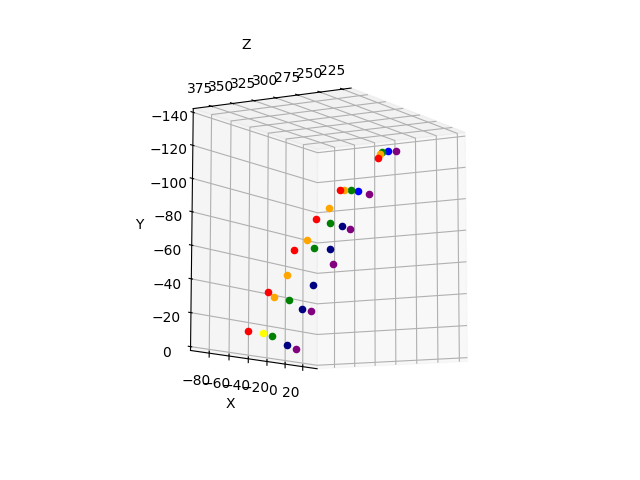

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df_abs.index:
    x, y, z = df_abs.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Fit a plane and get projections of the KPs on the plane

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

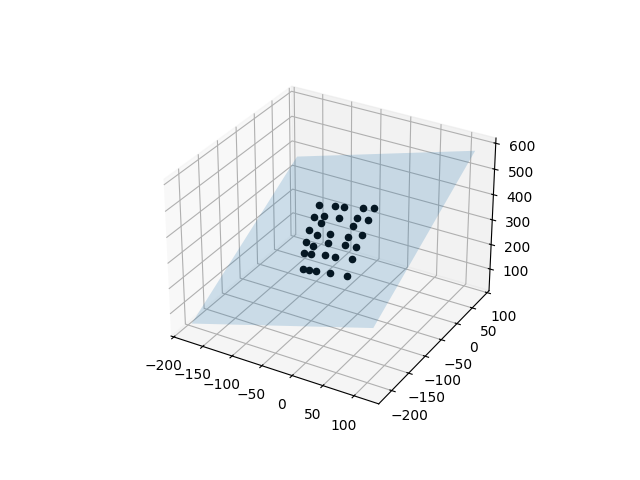

In [30]:
points = Points(df_abs.astype(float))
plane = Plane.best_fit(points)

plot_3d(
    points.plotter(c='black', s=20, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-150, 150), lims_y=(-150, 150)),
)

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

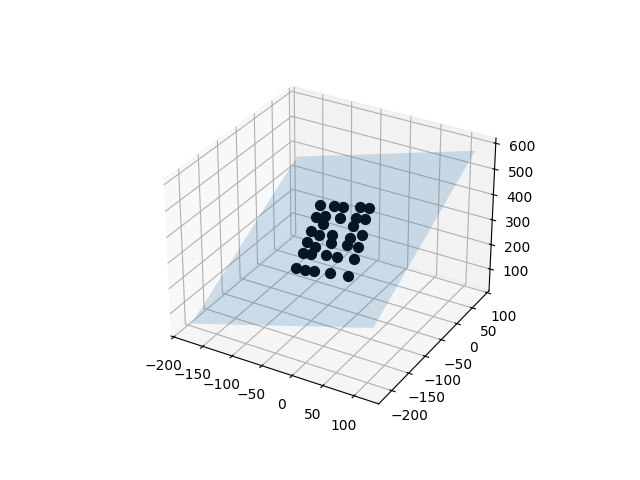

In [31]:
points2 = plane.project_points(df_abs.astype(float))
plot_3d(
    points2.plotter(c='k', s=50, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-150, 150), lims_y=(-150, 150)),
)

In [32]:
df_abs_fit = pd.DataFrame(points2, index=df.index, columns=df.columns)
df_abs_fit

,X,Y,Z
A1,-88.888366,-6.885379,339.330076
A4,-83.227704,-28.312338,320.151832
A8,-77.166861,-53.125192,297.599281
A11,-72.372011,-72.591824,279.933679
A14,-68.209790,-92.318557,261.547552
A18,-63.884415,-118.898074,235.882310
C4,-67.957871,-28.039048,331.065493
C6,-64.644023,-40.886486,319.510568
C9,-58.949455,-61.223158,301.532070
C12,-54.250998,-81.314129,283.125919


Text(0.5, 0, 'Z')

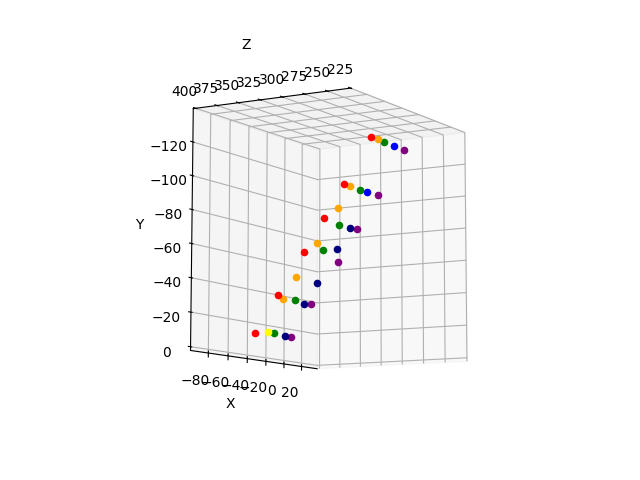

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df_abs_fit.index:
    x, y, z = df_abs_fit.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 9. Human pose estimation (3D)

In [34]:
from humanpose.pose3d import Body

[array([    -168.73,      14.826,   -0.039748]), array([     166.85,     -15.643,    0.040876])]
####################
[   -0.94089    -0.40845  0.00056449]
[array([    -162.85,      15.896,   -0.035009]), array([     161.11,     -16.587,    0.036283])]
####################
[   -0.86733    -0.34548  0.00063688]
[array([    -161.83,      16.012,   -0.035089]), array([     160.16,     -16.678,    0.036364])]
####################
[   -0.83668    -0.33319  0.00063727]
[array([    -159.18,      16.119,   -0.040365]), array([     157.56,      -16.77,    0.041724])]
####################
[   -0.81207    -0.32521  0.00067946]
[array([    -158.12,      16.469,   -0.040379]), array([     156.55,     -17.082,    0.041743])]
####################
[   -0.78668    -0.30693  0.00068205]
[array([    -157.38,      16.907,    -0.04003]), array([     155.81,     -17.483,    0.041401])]
####################
[   -0.78596    -0.28822  0.00068554]
[array([    -155.72,      17.219,   -0.040027]), array([     154

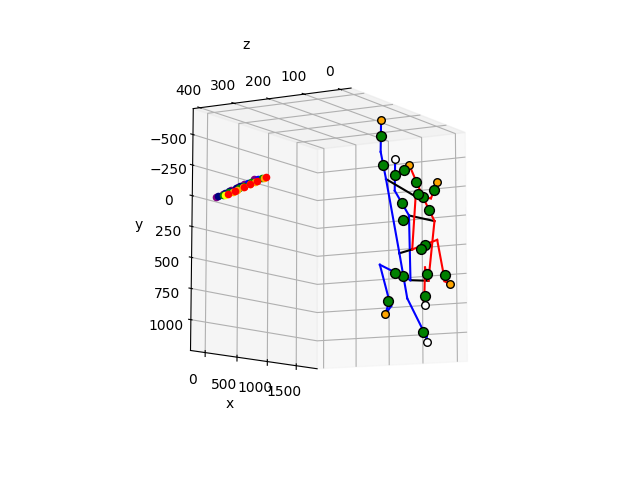

In [35]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
body = Body(0)
body.plot(ax)
body = Body(600)
body.plot(ax)
plt.show()

# 10. Solve PnP to standardize the viewpoint

In [115]:
kps = WallKeypoints('example', inverty=True)
coords_3d = kps.get_node_coords_all_3d()
img_coords = []
world_coords = []
for key in kps.get_node_names():
    img_coords.append(tuple(df.loc[key,['X', 'Y']]))
    # img_coords.append(tuple(df_fit.loc[key,['X', 'Y']]))
    world_coords.append(coords_3d[key])
world_coords = np.array(world_coords).astype('float32')
img_coords = np.array(img_coords).astype('float32')

In [116]:
success, rvec, tvec, inliers = cv2.solvePnPRansac(
    world_coords,
    img_coords,
    K,
    dist,
    flags=cv2.SOLVEPNP_ITERATIVE,
    reprojectionError=8.0,
    confidence=0.99
)

if success:
    print("Rotation Vector:\n", rvec)
    print("Translation Vector:\n", tvec)
else:
    print("PnP RANSAC failed.")

Rotation Vector:
 [[     1.4849]
 [   -0.19346]
 [    0.17173]]
Translation Vector:
 [[    -1080.9]
 [    -119.84]
 [     8175.1]]


In [117]:
# Extrinsic matrix
T = np.eye(4)
# Convert rotation vector to matrix
R, _ = cv2.Rodrigues(rvec)
T[:3, :3] = R
T[:3, 3] = tvec.flatten()
T

array([[    0.97242,    -0.23212,   -0.022969,     -1080.9],
       [ -0.0047136,    0.078894,    -0.99687,     -119.84],
       [    0.23321,     0.96948,    0.075623,      8175.1],
       [          0,           0,           0,           1]])

In [118]:
# Map the 3D point to 2D point 
points_2d, _ = cv2.projectPoints(world_coords, 
                                 rvec, tvec, 
                                 K, 
                                 dist) 

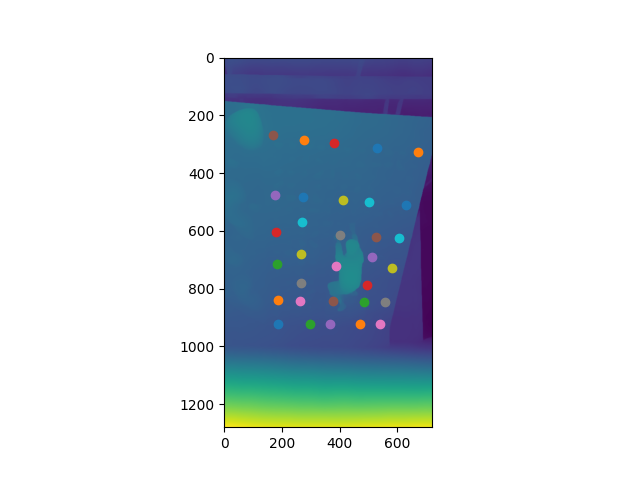

In [119]:
fig, ax = plt.subplots()
ax.imshow(depth_array['depths'][0,:,:])
for coords in points_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy)

In [120]:
kwargs = {
    'inverty': True,
    'rvec': rvec,
    'tvec': tvec, 
    'K': K, 
    'dist': dist

}
holds = Holds(**kwargs)
coords2d_holds = holds.get_projection()

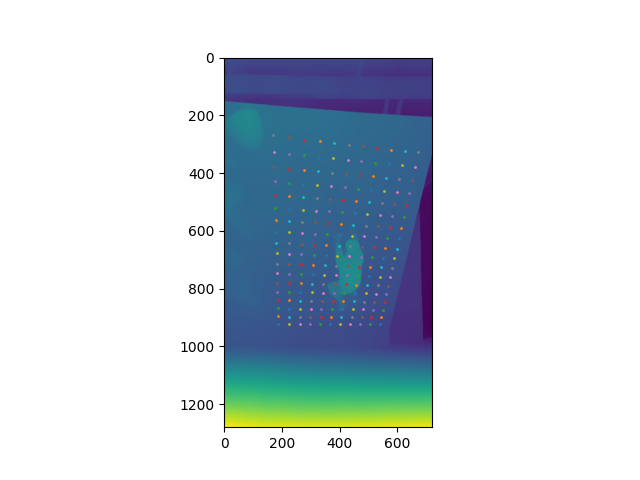

In [121]:
fig, ax = plt.subplots()
ax.imshow(depth_array['depths'][0,:,:])
for hold_name, coords in coords2d_holds.items():
    xx, yy = coords[0]
    ax.scatter(xx, yy, s=1)